Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License. 

## MAISI Mask Augmentation Example

### Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

### Setup imports

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

import monai
from monai.transforms import AsDiscrete, LoadImage, Orientation
from monai.utils import set_determinism
from monai.config import print_config

# Add MAISI folder to PATH
sys.path.append(os.path.dirname(os.getcwd()))
#
from scripts.augmentation import augmentation

set_determinism(38)
print_config()

MONAI version: 1.4.dev2425
Numpy version: 2.0.0
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: b5d71491b839191430b236bd3b233c5f29daf229
MONAI __file__: /home/<username>/code/forked/tutorials/.venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: NOT INSTALLED or UNKNOWN VERSION.
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INS

### Plotting functions

In [4]:
def find_label_center_loc(x):
    """
    Find center location of the binary mask
    Args:
        x: numpy array
    """
    label_loc = torch.where(x != 0)
    center_loc = []
    for loc in label_loc:
        unique_loc = torch.unique(loc)
        if len(unique_loc) == 0:
            center_loc.append(None)
        else:
            center_loc.append(unique_loc[len(unique_loc) // 2])

    return center_loc


def normalize_label_to_uint8(colorize, label, n_label):
    """
    Normalize image to uint8
    Args:
        image: numpy array
    """
    with torch.no_grad():
        post_label = AsDiscrete(to_onehot=n_label)
        label = post_label(label).permute(1, 0, 2, 3)
        label = F.conv2d(label, weight=colorize)
        label = torch.clip(label, 0, 1).squeeze().permute(1, 2, 0).cpu().numpy()

    draw_img = (label * 255).astype(np.uint8)

    return draw_img


def visualize_one_slice_in_3d_label(colorize, image, axis: int = 2, n_label=105, center=None):
    """
    Prepare a 2D image slice from a 3D image for visualization.
    Args:
        image: image numpy array, sized (H, W, D)
    """

    # draw image
    if center is None:
        center = image.shape[2:][axis] // 2
    if axis == 0:
        draw_img = normalize_label_to_uint8(colorize, image[..., center, :, :], n_label)
    elif axis == 1:
        draw_img = normalize_label_to_uint8(colorize, image[..., :, center, :], n_label)
    elif axis == 2:
        draw_img = normalize_label_to_uint8(colorize, image[..., :, :, center], n_label)
    else:
        raise ValueError("axis should be in [0,1,2]")
    return draw_img


def show_image(image):
    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("mask")
    plt.imshow(image)
    plt.show()


def to_shape(a, shape):
    x_, y_, z_ = shape
    x, y, z = a.shape
    x_pad = x_ - x
    y_pad = y_ - y
    z_pad = z_ - z
    return np.pad(
        a,
        (
            (x_pad // 2, x_pad // 2 + x_pad % 2),
            (y_pad // 2, y_pad // 2 + y_pad % 2),
            (z_pad // 2, z_pad // 2 + z_pad % 2),
        ),
        mode="constant",
    )


def get_xyz_plot(label, target_class_index, colorize, n_label):
    target_shape = list(label.shape[1:])
    seg_list = []
    center_loc_axis = find_label_center_loc(torch.flip(label[0, ...] == target_class_index, [-3, -2, -1]))

    for axis in range(3):
        center = center_loc_axis[axis]

        seg = visualize_one_slice_in_3d_label(
            colorize, torch.flip(label.unsqueeze(0), [-3, -2, -1]), axis, n_label, center
        ).transpose([2, 1, 0])
        seg = to_shape(seg, (3, max(target_shape), max(target_shape)))
        seg_list.append(seg)
        seg = np.concatenate(seg_list, axis=2).transpose([1, 2, 0])
    return seg

### Load example mask

In [5]:
loader = LoadImage(image_only=True, ensure_channel_first=True)
orientation = Orientation(axcodes="RAS")
volume = orientation(loader(os.path.join(os.getcwd(), "example_mask.nii.gz"))).to(torch.uint8)
volume_shape = list(volume.shape[1:])
print("volume shape", volume_shape)

volume shape [512, 512, 384]


### Plot lung tumor

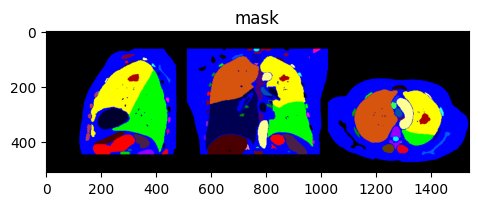

In [6]:
# create a random color map
colorize = torch.clip(torch.cat([torch.zeros(3, 1, 1, 1), torch.randn(3, 200, 1, 1)], 1), 0, 1)
mask = get_xyz_plot(volume, target_class_index=23, colorize=colorize, n_label=201)
show_image(mask)

### Apply augmentation to lung tumor

In [7]:
volume_aug = augmentation(volume.unsqueeze(0), volume_shape)

augmenting lung tumor
metatensor(23107.) | metatensor(16309.8008)


### Plot augmented lung tumor

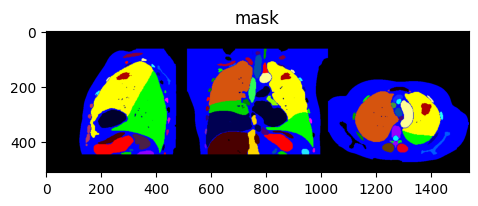

In [8]:
augmented_mask = get_xyz_plot(volume_aug.squeeze(0), target_class_index=23, colorize=colorize, n_label=201)
show_image(augmented_mask)